# Behaviour Cloning Journey — Passive Walker  

This notebook walks through how we replace hand-crafted FSM controllers with small neural MLPs, variant by variant. You can toggle GPU acceleration via `USE_GPU_NOTEBOOK=True` at the top of each cell.

| Section | Variant            | Labels                         | MLP output dim | Key change                                 |
|---------|--------------------|--------------------------------|----------------|--------------------------------------------|
| 1       | Hip-only (MSE)     | FSM hip                        | 1              | Baseline 1-D MLP for hip                   |
| 2       | Knee-only (MSE)    | FSM left & right knees         | 2              | Two separate 1-D MLPs (one per knee)       |
| 3       | Hip + Knee (MSE)   | hip, left_knee, right_knee     | 3              | Single 3-D MLP controlling all three joints|
| 4       | Alt. losses        | MSE, Huber, L1 on 3-D output   | 3              | Compare different loss functions           |
| 5       | Combined loss      | MSE + symmetry + smoothness + energy + weight decay | 3 | Composite loss regularisation |
| 6       | Comparison & GUI   | All variants                   | —              | Side-by-side loss plots and short rollouts |

Each variant follows these four mini-steps:

1. **Collect FSM demo data**  
2. **Train** a small MLP via behavior cloning  
3. **Visualise** label distribution, loss curve, prediction vs. truth  
4. **Run** a short GUI roll-out to inspect gait  

Let’s get started with Section 1: Hip-only MSE.  

## 1 Setup & Imports

In [1]:
from pathlib import Path
import numpy as np
import jax, jax.numpy as jnp
import optax, equinox as eqx
import pickle

from passive_walker.constants            import XML_PATH, BC_DATA
from passive_walker.envs.mujoco_fsm_env   import PassiveWalkerEnv
from passive_walker.bc.plotters           import plot_label_hist, plot_loss_curve, plot_pred_vs_true
from passive_walker.controllers.nn.hip_nn import HipController
from passive_walker.bc.hip_mse.train      import train_nn_controller

print("Repo ready — model XML →", XML_PATH)

Repo ready — model XML → /home/yunusdanabas/ENS492/passive_walker_rl/passiveWalker_model.xml


### Optional — choose CPU / GPU for this notebook

In [2]:
# Run once; change to True to force GPU if available
USE_GPU_NOTEBOOK = False            # ← flip anytime
import os, jax
os.environ["JAX_PLATFORM_NAME"] = "gpu" if USE_GPU_NOTEBOOK else "cpu"
print("Running on:", jax.default_backend())

Running on: cpu


## 2 Hip‐only MSE   
### 2.1 Collect a mini demo set  
The demo collection uses FSM‐only hip control in MuJoCo.  

Collected obs (20000, 11), labels (20000, 1)


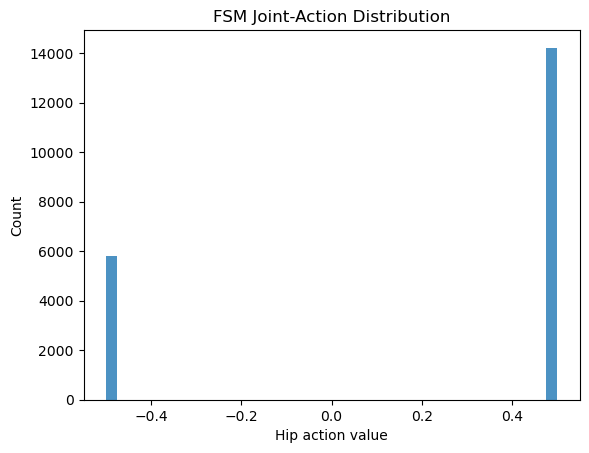

In [3]:
from passive_walker.bc.hip_mse.collect import collect_demo_data

DEMO_STEPS = 20_000

env_demo = PassiveWalkerEnv(
    xml_path=str(XML_PATH),
    simend=30,
    use_nn_for_hip=False,
    use_gui=False
)
obs, labels = collect_demo_data(env_demo, num_steps=DEMO_STEPS)
env_demo.close()

print(f"Collected obs {obs.shape}, labels {labels.shape}")
plot_label_hist(np.array(labels))

### 2.2 Train a MLP 
(For a full run, use the CLI script in `bc/hip_mse/run_pipeline.py`.)

[train] epoch 00  loss=0.0509
[train] epoch 01  loss=0.0388
[train] epoch 02  loss=0.0370
[train] epoch 03  loss=0.0330
[train] epoch 04  loss=0.0330
[train] epoch 05  loss=0.0307
[train] epoch 06  loss=0.0301
[train] epoch 07  loss=0.0260
[train] epoch 08  loss=0.0240
[train] epoch 09  loss=0.0237
[train] epoch 10  loss=0.0210
[train] epoch 11  loss=0.0195
[train] epoch 12  loss=0.0198
[train] epoch 13  loss=0.0192
[train] epoch 14  loss=0.0166
[train] epoch 15  loss=0.0206
[train] epoch 16  loss=0.0151
[train] epoch 17  loss=0.0140
[train] epoch 18  loss=0.0149
[train] epoch 19  loss=0.0130
[train] epoch 20  loss=0.0126
[train] epoch 21  loss=0.0117
[train] epoch 22  loss=0.0113
[train] epoch 23  loss=0.0110
[train] epoch 24  loss=0.0105
[train] epoch 25  loss=0.0101
[train] epoch 26  loss=0.0102
[train] epoch 27  loss=0.0090
[train] epoch 28  loss=0.0125
[train] epoch 29  loss=0.0105
[train] epoch 30  loss=0.0104
[train] epoch 31  loss=0.0113
[train] epoch 32  loss=0.0086
[train] ep

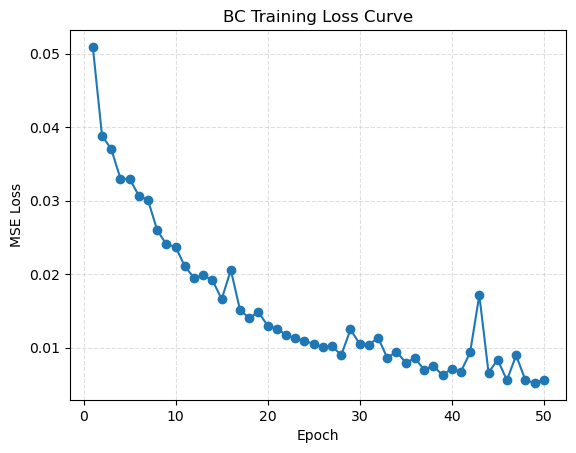

In [4]:
from passive_walker.bc.hip_mse.train import train_nn_controller

# Hyper-parameters
EPOCHS, BATCH, LR = 50, 32, 1e-4

# Initialize model & optimizer
hip_model     = HipController(input_size=obs.shape[1], hidden_size=128)
optimizer = optax.adam(LR)

# Train (dont auto-plot — we’ll plot below)
hip_model, loss_hist = train_nn_controller(
    nn_controller=hip_model,
    optimizer=optimizer,
    demo_obs=obs,
    demo_labels=labels,
    num_epochs=EPOCHS,
    batch_size=BATCH,
    plot_loss=False,    # set True if you want to auto-save the plot to DATA_DIR
)

# Plot the training loss curve
plot_loss_curve(loss_hist)

### 2.3 Scatter: prediction vs ground-truth

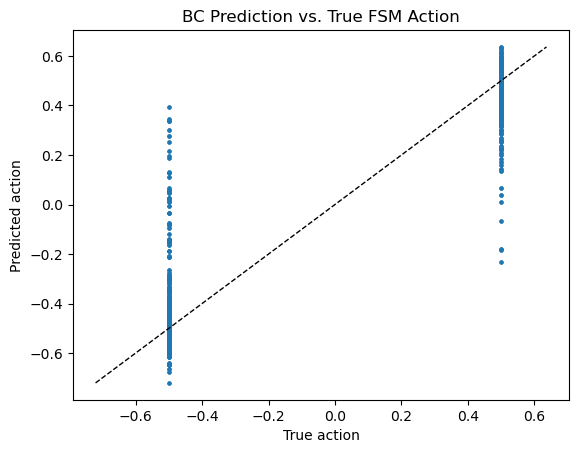

In [5]:
preds = np.array([hip_model(jnp.array(o)) for o in obs])
plot_pred_vs_true(np.array(labels), preds)

### 2.4 GUI roll-out (10 s)
Run only on a machine with a display.

In [6]:
import glfw
env_test_hip = PassiveWalkerEnv(
    xml_path=str(XML_PATH),
    simend=10.0,
    use_nn_for_hip=True,
    use_gui=True
)
obs, done, total = env_test_hip.reset(), False, 0.0
while not done and not glfw.window_should_close(env_test_hip.window):
    act = np.array(hip_model(jnp.array(obs)))
    obs, rew, done, _ = env_test_hip.step(act)
    total += rew
    env_test_hip.render()
env_test_hip.close()
print("GUI rollout total reward:", total)

GUI rollout total reward: 4323.94714132628


## 3 Knee-only MSE  
We now repeat the pipeline, but recording **left & right knee actions**.

Collected knee demos: obs (20000, 11), labels (20000, 2)


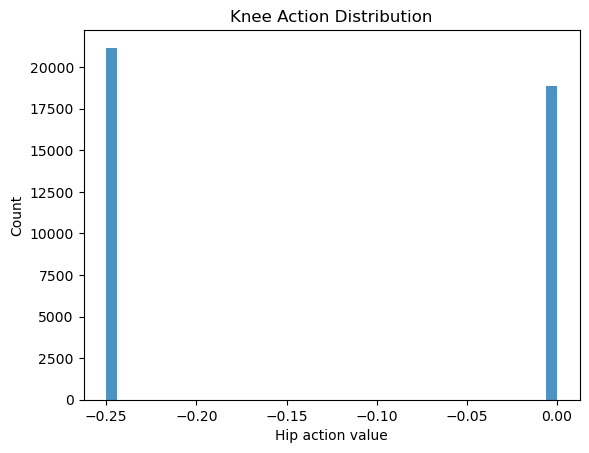

In [7]:
from passive_walker.bc.knee_mse        import set_device, XML_PATH as K_XML
from passive_walker.bc.knee_mse.collect import collect_demo_data
from passive_walker.envs.mujoco_fsm_env  import PassiveWalkerEnv

# 1) Configure CPU/GPU
set_device(USE_GPU_NOTEBOOK)

# 2) Collect demos
DEMO_STEPS_KNEE = 20_000
env_knee = PassiveWalkerEnv(
    xml_path=K_XML,
    simend=30,
    use_nn_for_hip=False,
    use_nn_for_knees=False,
    use_gui=False
)
obs_k, labels_k = collect_demo_data(env_knee, num_steps=DEMO_STEPS_KNEE)
env_knee.close()

# 3) Report & visualize
print(f"Collected knee demos: obs {obs_k.shape}, labels {labels_k.shape}")
plot_label_hist(np.array(labels_k), title="Knee Action Distribution")

### 3.2 Train a MLP (knee)

[train] epoch 00  loss=0.0035
[train] epoch 01  loss=0.0028
[train] epoch 02  loss=0.0023
[train] epoch 03  loss=0.0024
[train] epoch 04  loss=0.0019
[train] epoch 05  loss=0.0019
[train] epoch 06  loss=0.0016
[train] epoch 07  loss=0.0016
[train] epoch 08  loss=0.0013
[train] epoch 09  loss=0.0014
[train] epoch 10  loss=0.0013
[train] epoch 11  loss=0.0011
[train] epoch 12  loss=0.0012
[train] epoch 13  loss=0.0011
[train] epoch 14  loss=0.0011
[train] epoch 15  loss=0.0014
[train] epoch 16  loss=0.0011
[train] epoch 17  loss=0.0009
[train] epoch 18  loss=0.0009
[train] epoch 19  loss=0.0011
[train] epoch 20  loss=0.0010
[train] epoch 21  loss=0.0011
[train] epoch 22  loss=0.0010
[train] epoch 23  loss=0.0008
[train] epoch 24  loss=0.0008
[train] epoch 25  loss=0.0010
[train] epoch 26  loss=0.0010
[train] epoch 27  loss=0.0007
[train] epoch 28  loss=0.0007
[train] epoch 29  loss=0.0007
[train] epoch 30  loss=0.0007
[train] epoch 31  loss=0.0007
[train] epoch 32  loss=0.0006
[train] ep

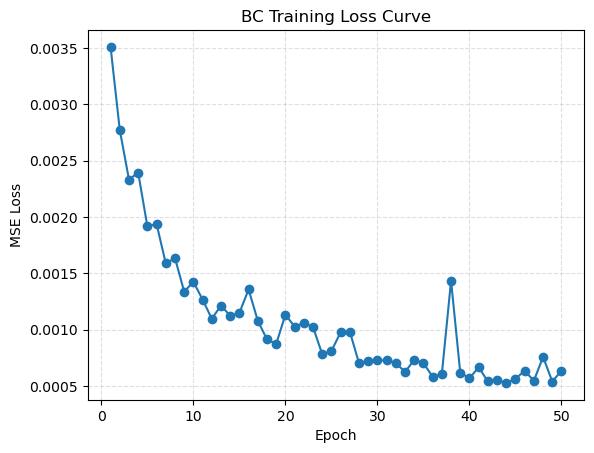

In [8]:
from passive_walker.controllers.nn.knee_nn import KneeController
from passive_walker.bc.knee_mse.train import train_nn_controller as train_knee_controller

# Hyper-parameters
EPOCHS_K, BATCH_K, LR_K = 50, 32, 1e-4

# Initialize model & optimizer
knee_model = KneeController(input_size=obs_k.shape[1], hidden_size=128)
knee_opt   = optax.adam(LR_K)

# Train (plot_loss=False means we’ll plot manually below)
knee_model, knee_loss_hist = train_knee_controller(
    nn_controller=knee_model,
    optimizer=knee_opt,
    demo_obs=obs_k,
    demo_labels=labels_k,
    num_epochs=EPOCHS_K,
    batch_size=BATCH_K,
    plot_loss=False,
)

# Plot the knee training loss curve
plot_loss_curve(knee_loss_hist)

### 3.3 Prediction vs Ground-Truth Scatter (Knee)

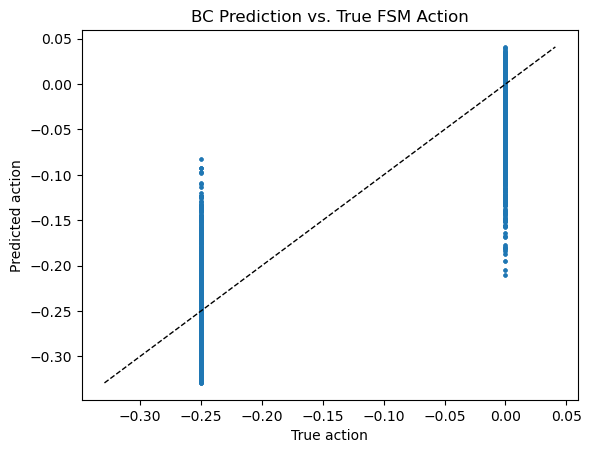

In [9]:
preds_k = np.array([knee_model(jnp.array(o)) for o in obs_k])
plot_pred_vs_true(np.array(labels_k), preds_k)

In [10]:
import glfw
env_test_knee = PassiveWalkerEnv(
    xml_path=str(XML_PATH),
    simend=10.0,
    use_nn_for_hip=False,
    use_nn_for_knees=True,
    use_gui=True
)
obs, done, total = env_test_knee.reset(), False, 0.0
while not done and not glfw.window_should_close(env_test_knee.window):
    act = np.array(knee_model(jnp.array(obs)))
    obs, rew, done, _ = env_test_knee.step(act)
    total += rew
    env_test_knee.render()
env_test_knee.close()
print("GUI rollout total reward:", total)

GUI rollout total reward: 1573.394546019688


## 4 Hip + Knee MSE  

We now train one MLP to predict **all three** actuator commands (hip, left knee, right knee).

### 4.1 Collect a mini demo set

Collected hip+knee demos: obs (20000, 11), labels (20000, 3)


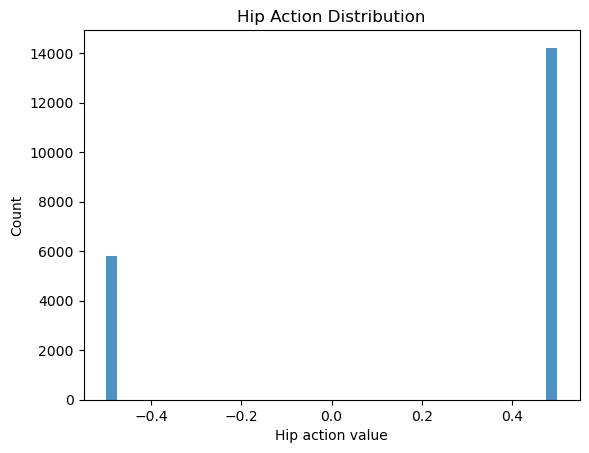

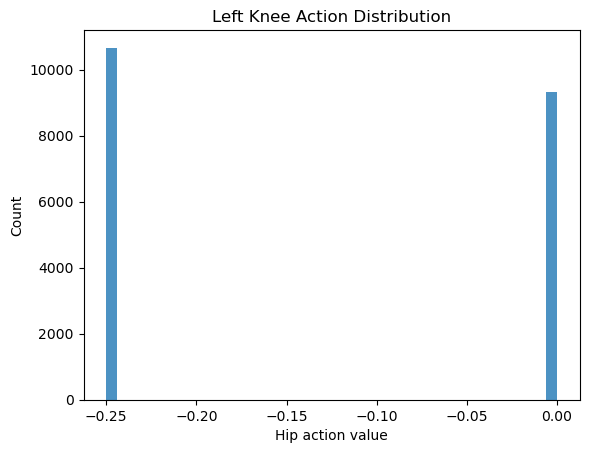

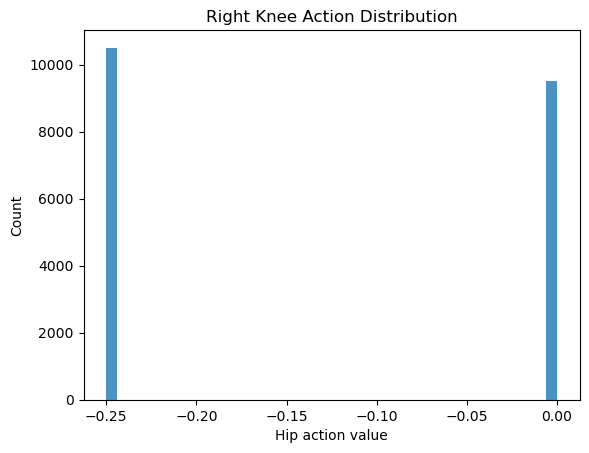

In [11]:
from passive_walker.bc.hip_knee_mse import set_device, XML_PATH
from passive_walker.bc.hip_knee_mse.collect import collect_demo_data
from passive_walker.envs.mujoco_fsm_env import PassiveWalkerEnv

# 1) CPU/GPU toggle
set_device(USE_GPU_NOTEBOOK)

# 2) Collect demos
DEMO_STEPS_HK = 20_000

env_hk = PassiveWalkerEnv(
    xml_path=str(XML_PATH),
    simend=30,
    use_nn_for_hip=False,
    use_nn_for_knees=False,
    use_gui=False
)
obs_hk, labels_hk = collect_demo_data(env_hk, num_steps=DEMO_STEPS_HK)
env_hk.close()

# 3) Report & visualize
print(f"Collected hip+knee demos: obs {obs_hk.shape}, labels {labels_hk.shape}")
plot_label_hist(np.array(labels_hk[:,0]), title="Hip Action Distribution")
plot_label_hist(np.array(labels_hk[:,1]), title="Left Knee Action Distribution")
plot_label_hist(np.array(labels_hk[:,2]), title="Right Knee Action Distribution")

### 4.2 Train a MLP

[train] epoch 01  loss=0.0139
[train] epoch 02  loss=0.0137
[train] epoch 03  loss=0.0082
[train] epoch 04  loss=0.0067
[train] epoch 05  loss=0.0056
[train] epoch 06  loss=0.0048
[train] epoch 07  loss=0.0046
[train] epoch 08  loss=0.0029
[train] epoch 09  loss=0.0026
[train] epoch 10  loss=0.0030
[train] epoch 11  loss=0.0031
[train] epoch 12  loss=0.0024
[train] epoch 13  loss=0.0023
[train] epoch 14  loss=0.0028
[train] epoch 15  loss=0.0028
[train] epoch 16  loss=0.0018
[train] epoch 17  loss=0.0019
[train] epoch 18  loss=0.0018
[train] epoch 19  loss=0.0019
[train] epoch 20  loss=0.0043


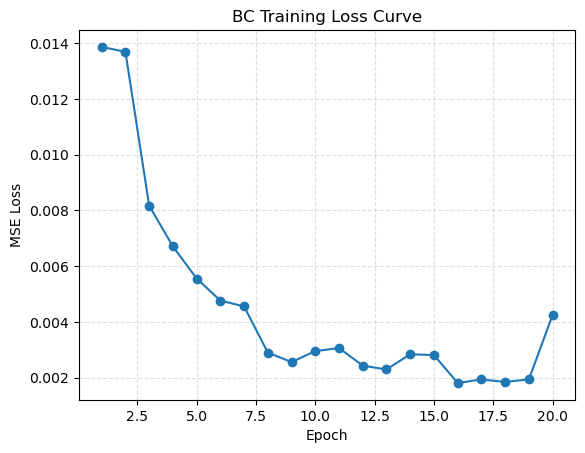

In [ ]:
from passive_walker.controllers.nn.hip_knee_nn import HipKneeController
from passive_walker.bc.hip_knee_mse.train import train_nn_controller as train_hk

EPOCHS_HK, BATCH_HK, LR_HK =20, 32, 1e-3

# Initialize model & optimizer
hk_model = HipKneeController(input_size=obs_hk.shape[1], hidden_size=128)
hk_opt   = optax.adam(LR_HK)

# Train & record loss
hk_model, hk_loss_hist = train_hk(
    model=hk_model,
    optimizer=hk_opt,
    obs=obs_hk,
    labels=labels_hk,
    epochs=EPOCHS_HK,
    batch=BATCH_HK
)

# Plot loss curve
plot_loss_curve(hk_loss_hist)

### 4.3 Prediction vs Ground-Truth  
Scatter for each action channel.

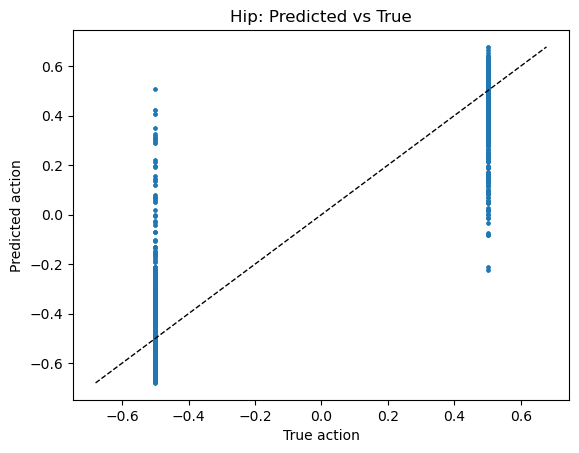

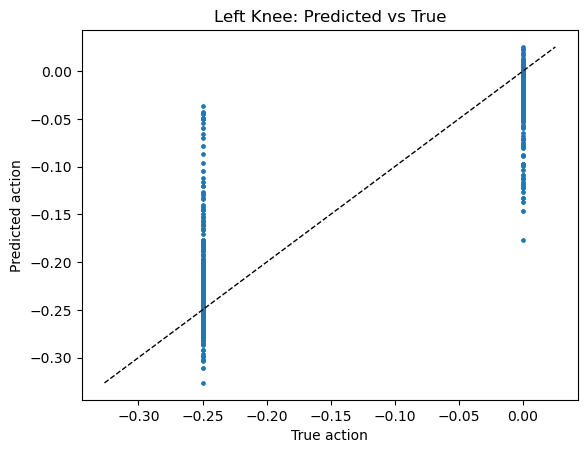

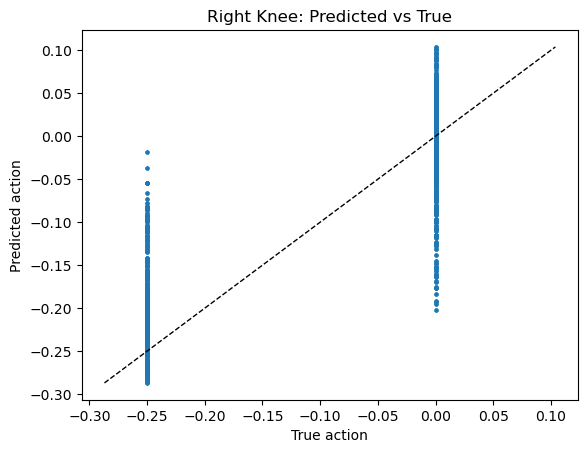

In [13]:
preds_hk = np.stack([np.array(hk_model(jnp.array(o))) for o in obs_hk], axis=0)

# Hip channel
plot_pred_vs_true(
    true=labels_hk[:,0],
    pred=preds_hk[:,0],
    title="Hip: Predicted vs True"
)

# Left knee channel
plot_pred_vs_true(
    true=labels_hk[:,1],
    pred=preds_hk[:,1],
    title="Left Knee: Predicted vs True"
)

# Right knee channel
plot_pred_vs_true(
    true=labels_hk[:,2],
    pred=preds_hk[:,2],
    title="Right Knee: Predicted vs True"
)

### 4.4 GUI Roll-Out (10 s)  
Verify both hip and knees are now controlled by the MLP.

In [14]:
env_test_hipKnee = PassiveWalkerEnv(
    xml_path=str(XML_PATH),
    simend=10.0,
    use_nn_for_hip=True,
    use_nn_for_knees=True,
    use_gui=True
)
obs, done, total = env_test_hipKnee.reset(), False, 0.0
while not done and not glfw.window_should_close(env_test_hipKnee.window):
    act = np.array(hk_model(jnp.array(obs)))   # 3-vector
    obs, r, done, _ = env_test_hipKnee.step(act)
    total += r
    env_test_hipKnee.render()
env_test_hipKnee.close()
print("Hip+Knee GUI reward:", total)

Hip+Knee GUI reward: 1500.9172999925481


## 5 Alternative-Loss Comparison

In this section we will:

1. Collect a small hip+knee demo set  
2. Train four variants (MSE, Huber, L1, Combined) **in-notebook**  
3. Plot their loss curves side-by-side  
4. Run a short GUI rollout for each and compare total reward  
5. Play out the best one for a longer test  

In [18]:
# 5.1 Setup & Imports
import numpy as np
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from mujoco.glfw import glfw

from passive_walker.envs.mujoco_fsm_env import PassiveWalkerEnv
from passive_walker.controllers.nn.hip_knee_nn import HipKneeController
from passive_walker.bc.hip_knee_alternatives import set_device, XML_PATH
from passive_walker.bc.hip_knee_alternatives.collect import collect_demo_data

import passive_walker.bc.hip_knee_alternatives.train_mse     as mse_mod
import passive_walker.bc.hip_knee_alternatives.train_huber   as huber_mod
import passive_walker.bc.hip_knee_alternatives.train_l1      as l1_mod
import passive_walker.bc.hip_knee_alternatives.train_combined as comb_mod

# Toggle GPU if desired
USE_GPU_NOTEBOOK = False
set_device(USE_GPU_NOTEBOOK)

# Hyperparameters
DEMO_STEPS   = 5_000
EPOCHS       = 30
BATCH_SIZE   = 32
HIDDEN_SIZE  = 128
LR           = 1e-3
SIM_DURATION = 15.0
SEED         = 42

# Combined-loss weights
ALPHA_SYM    = 0.1
BETA_SMOOTH  = 0.1
GAMMA_ENERGY = 0.01

np.random.seed(SEED)

### 5.2 Collect a small demo set

In [ ]:
env = PassiveWalkerEnv(
    xml_path=XML_PATH,
    simend=30,
    use_nn_for_hip=False,
    use_nn_for_knees=False,
    use_gui=False
)
obs, labels = collect_demo_data(env, num_steps=DEMO_STEPS)
env.close()

print(f"Collected: obs={obs.shape}, labels={labels.shape}")

Collected: obs=(5000, 11), labels=(5000, 3)


### 5.3 Train all four variants

In [20]:
variants = {
    "mse":      mse_mod.train,
    "huber":    huber_mod.train_nn_controller,
    "l1":       l1_mod.train_nn_controller,
    "combined": comb_mod.train_nn_controller,
}

results = {}
for name, train_fn in variants.items():
    print(f"\n--- Training {name.upper()} ---")
    key = jax.random.PRNGKey(SEED)
    model = HipKneeController(input_size=obs.shape[1], hidden_size=HIDDEN_SIZE, key=key)
    optimizer = optax.adam(LR)

    if name == "combined":
        # signature: train_nn_controller(model, optimizer, obs, labels,
        #                               epochs, batch,
        #                               alpha_sym, beta_smooth, gamma_energy)
        model, loss_hist = train_fn(
            model, optimizer, obs, labels,
            epochs=EPOCHS,
            batch=BATCH_SIZE,
            alpha_sym=ALPHA_SYM,
            beta_smooth=BETA_SMOOTH,
            gamma_energy=GAMMA_ENERGY
        )
    else:
        # signature: train(model, optimizer, obs, labels, epochs, batch)
        model, loss_hist = train_fn(
            model, optimizer, obs, labels,
            epochs=EPOCHS,
            batch=BATCH_SIZE
        )

    results[name] = (model, loss_hist)


--- Training MSE ---
[MSE] epoch 1/30 loss=0.0182
[MSE] epoch 2/30 loss=0.0197
[MSE] epoch 3/30 loss=0.0137
[MSE] epoch 4/30 loss=0.0123
[MSE] epoch 5/30 loss=0.0114
[MSE] epoch 6/30 loss=0.0117
[MSE] epoch 7/30 loss=0.0116
[MSE] epoch 8/30 loss=0.0097
[MSE] epoch 9/30 loss=0.0079
[MSE] epoch 10/30 loss=0.0099
[MSE] epoch 11/30 loss=0.0068
[MSE] epoch 12/30 loss=0.0095
[MSE] epoch 13/30 loss=0.0075
[MSE] epoch 14/30 loss=0.0057
[MSE] epoch 15/30 loss=0.0096
[MSE] epoch 16/30 loss=0.0045
[MSE] epoch 17/30 loss=0.0054
[MSE] epoch 18/30 loss=0.0060
[MSE] epoch 19/30 loss=0.0044
[MSE] epoch 20/30 loss=0.0038
[MSE] epoch 21/30 loss=0.0065
[MSE] epoch 22/30 loss=0.0035
[MSE] epoch 23/30 loss=0.0042
[MSE] epoch 24/30 loss=0.0035
[MSE] epoch 25/30 loss=0.0066
[MSE] epoch 26/30 loss=0.0033
[MSE] epoch 27/30 loss=0.0034
[MSE] epoch 28/30 loss=0.0030
[MSE] epoch 29/30 loss=0.0031
[MSE] epoch 30/30 loss=0.0033

--- Training HUBER ---
[HUBER] epoch 01  loss=0.0099
[HUBER] epoch 02  loss=0.0083
[HU

### 5.4 Plot training loss curves

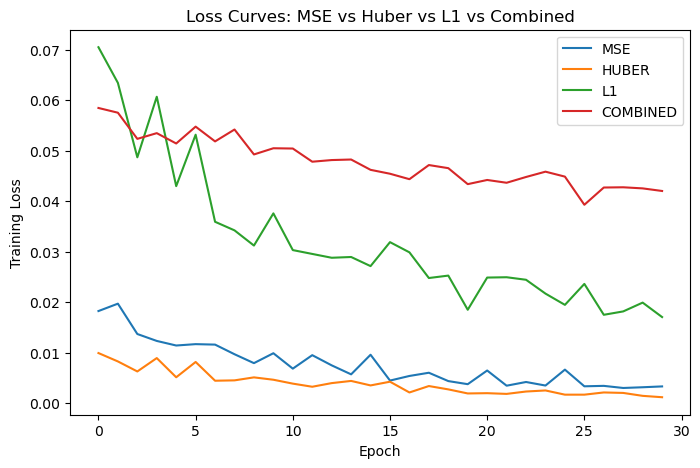

In [21]:
plt.figure(figsize=(8,5))
for name, (_, hist) in results.items():
    plt.plot(hist, label=name.upper())
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Loss Curves: MSE vs Huber vs L1 vs Combined")
plt.legend()
plt.show()

### 5.5 Short GUI rollouts & reward comparison

In [22]:
def gui_rollout(model, duration):
    env = PassiveWalkerEnv(
        xml_path=XML_PATH,
        simend=duration,
        use_nn_for_hip=True,
        use_nn_for_knees=True,
        use_gui=True
    )
    obs = env.reset()
    done = False
    total = 0.0
    while not done and not glfw.window_should_close(env.window):
        act = np.array(model(jnp.array(obs)))
        obs, r, done, _ = env.step(act)
        total += r
        env.render()
    env.close()
    return total

rewards = {}
for name, (model, _) in results.items():
    print(f"\n{name.upper()} rollout:")
    rewards[name] = gui_rollout(model, SIM_DURATION)
    print(f"  Reward = {rewards[name]:.3f}")

import pandas as pd
pd.DataFrame.from_dict(rewards, orient='index', columns=['Total Reward'])


MSE rollout:
  Reward = 2549.993

HUBER rollout:
  Reward = 2189.168

L1 rollout:
  Reward = 3853.564

COMBINED rollout:
  Reward = 1622.426


,Total Reward
mse,2549.993440
huber,2189.168402
l1,3853.564022
combined,1622.426227


### 5.6 Play best variant longer

In [ ]:
best = max(rewards, key=rewards.get)
print(f"Best variant: {best.upper()} (reward {rewards[best]:.3f})")

print("Playing best for 2× duration…")
_ = gui_rollout(results[best][0], SIM_DURATION * 2)